# Wrangle

In [10]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from fitter import Fitter


def read_data(file):
    """Reads the first 4 columns from the given file and drops empty rows."""
    data = pd.read_csv(file, delimiter=',', usecols=[0, 1, 2, 3],
                       parse_dates=[[0, 1]])
    data.columns = ['date', 'm', 'v']
    data = data[data['date'] != 'nan nan']
    data = data.dropna(how='all')
    data['date'] = pd.to_datetime(data['date'])
    return data


data_1 = read_data('data/out_1.csv')
data_1['zone'] = 1
data_2 = read_data('data/out_2.csv')
data_2['zone'] = 2
df = pd.concat([data_1, data_2])

# Time Differences and Energy

In [11]:
def get_time_differences(df):
    """Returns the time differences between rocks in hours."""
    return df['date'].diff().dt.total_seconds() / 3600


def add_time_differences(df):
    """Adds the time differences to the dataframe."""
    df['time_differences'] = get_time_differences(df)
    return df


def add_energy(df):
    """Adds the energy to the dataframe."""
    df['e'] = 0.5 * df['m'] * df['v'] ** 2
    return df


def reorder_columns(df):
    """Reorders the columns of the dataframe."""
    return df[['zone', 'date', 'time_differences', 'm', 'v', 'e']]


data_1 = reorder_columns(add_energy(add_time_differences(data_1)))
data_2 = reorder_columns(add_energy(add_time_differences(data_2)))
df = reorder_columns(add_energy(add_time_differences(df)))
df['zone'] = df['zone'].astype('category')
data_1.to_csv('data/data_1.csv', index=False)
data_2.to_csv('data/data_1.csv', index=False)
df.to_csv('data/data.csv', index=False)

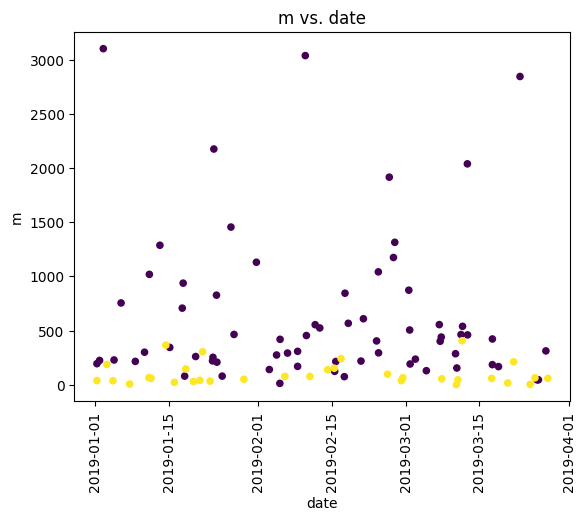

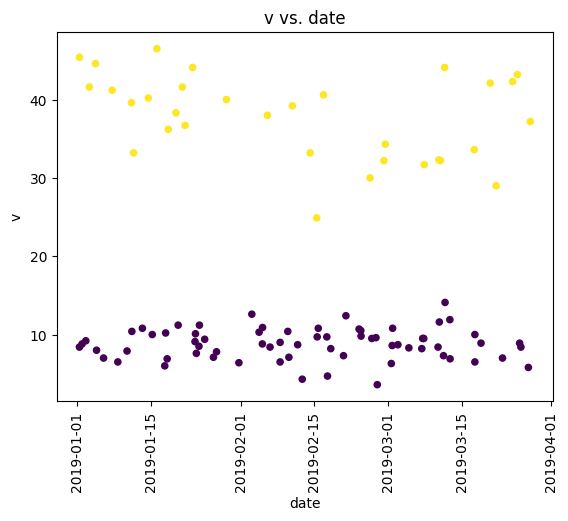

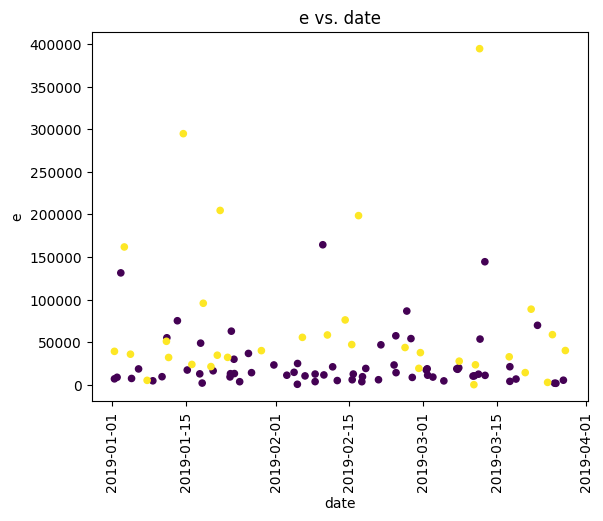

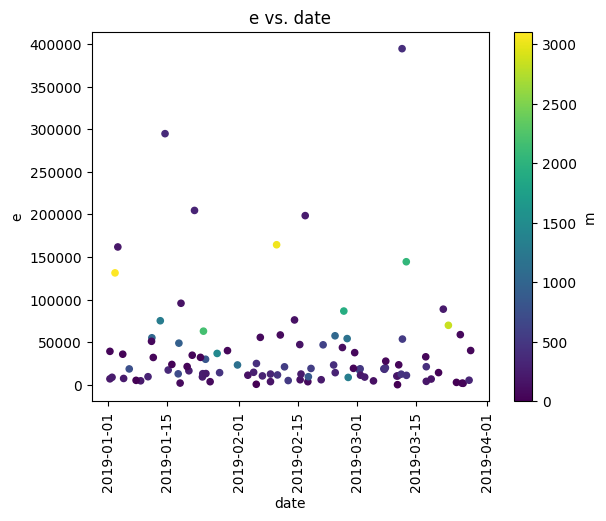

In [12]:
def scatter_plot(df: pd.DataFrame, col: str, c='zone', colorbar=False,
                 colormap='viridis'):
    """Plots the given column of the given dataframe as a scatter plot."""
    df['date'] = pd.to_datetime(df['date'])
    ax = df.plot.scatter(x='date', y=col, c=c, colorbar=colorbar,
                         colormap=colormap, title=f'{col} vs. date')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=90)


for col in ['m', 'v', 'e']:
    scatter_plot(df, col)
scatter_plot(df, 'e', c='m', colorbar=True)
plt.show()

In [13]:
def plot_histogram(df: pd.DataFrame, col: str, zone: int):
    """Plots the given column of the given dataframe as a histogram."""
    df[col].hist(bins=np.sqrt(len(df[col])).astype(int) * 6)
    plt.title(f'{col.upper()} for Zone {zone}')
    plt.xlabel(col.upper())
    plt.ylabel('Frequency')
    plt.show()


for col in ['m', 'v', 'e']:
    for zone in [1, 2]:
        plot_histogram(df[df['zone'] == zone], col, zone)


NameError: name 'np' is not defined

# Fit Distributions

In [14]:
def fit_common_distributions(data):
    """Fits the given data to the most common distributions and returns the fitted object."""
    f = Fitter(data)
    f.fit()
    return f


def show_best_distribution(data):
    """Fits the given data to the most common distributions, prints the best distribution and shows a plot of the best distributions."""
    f = fit_common_distributions(data)
    print(f.get_best())
    f.summary()

Fitting 110 distributions:  36%|███▋      | 40/110 [00:04<00:06, 10.65it/s]/home/nod0n/.pyenv/versions/cwm1/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3485: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  t1 = integrate.quad(llc, -np.inf, x)[0]
Fitting 110 distributions:  69%|██████▉   | 76/110 [00:08<00:06,  5.48it/s]SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitting 110 distributions:  97%|█████████▋| 107/110 [00:17<00:02,  1.13it/s]/home/nod0n/.pyenv/versions/cwm1/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain

{'nakagami': {'nu': 0.29474316775462595, 'loc': -2.8064802368464363e-30, 'scale': 40.78237930942086}}


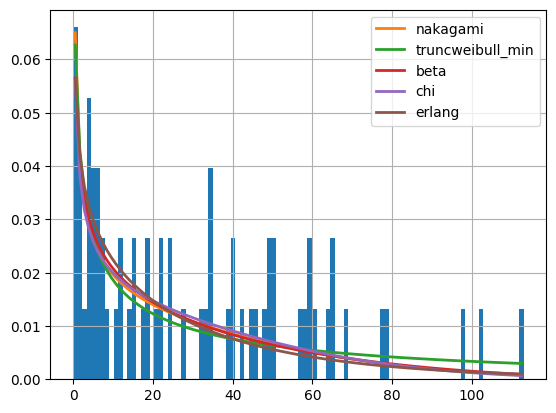

In [15]:
show_best_distribution(df[df['zone'] == 1]['time_differences'].dropna().values)

/home/nod0n/.pyenv/versions/cwm1/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/nod0n/.pyenv/versions/cwm1/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 110 distributions:  87%|███

{'moyal': {'loc': 35.81187910728692, 'scale': 21.238206682662174}}


/home/nod0n/.pyenv/versions/cwm1/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


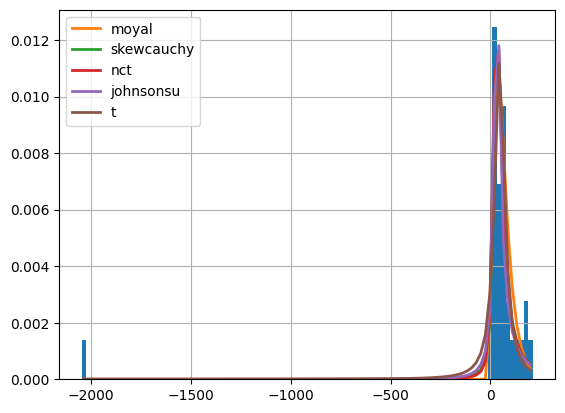

In [16]:
show_best_distribution(df[df['zone'] == 2]['time_differences'].dropna().values)

In [17]:
show_best_distribution(df[df['zone'] == 1]['m'].dropna().values)

/home/nod0n/.pyenv/versions/cwm1/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/nod0n/.pyenv/versions/cwm1/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 110 distributions:  93%|███

{'gennorm': {'beta': 0.4279160801639092, 'loc': 219.99999994398019, 'scale': 35.86654433090574}}
Error in callback <function _draw_all_if_interactive at 0x7f39afea3920> (for post_execute):


/home/nod0n/.pyenv/versions/cwm1/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/nod0n/.pyenv/versions/cwm1/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,

KeyboardInterrupt



Error in callback <function flush_figures at 0x7f398d261260> (for post_execute):



KeyboardInterrupt



In [18]:
show_best_distribution(df[df['zone'] == 2]['m'].dropna().values)

/home/nod0n/.pyenv/versions/cwm1/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/nod0n/.pyenv/versions/cwm1/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 110 distributions:   2%|▏  

KeyboardInterrupt: 

In [ ]:
show_best_distribution(df[df['zone'] == 1]['v'].dropna().values)

In [ ]:
show_best_distribution(df[df['zone'] == 2]['v'].dropna().values)

In [ ]:
show_best_distribution(df[df['zone'] == 1]['e'].dropna().values)

In [ ]:
show_best_distribution(df[df['zone'] == 2]['e'].dropna().values)